In [1]:
import glob
from pathlib import Path
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bioframe as bf
from cycler import cycler

# -------------------------------------------------------------------
# 1. Config
# -------------------------------------------------------------------
base_dir = Path("..")
resolutions_kb = [25, 50, 100, 250, 500]

# We'll use the finest resolution as the "base" to map others onto
base_resolution = min(resolutions_kb)

COORD_COLS_STD = ["chrom", "start", "end"]

In [2]:
# -------------------------------------------------------------------
# 2. Load parquet file per resolution (one file per resolution)
#    ../jointly-[resolution]kb/*post_processed.pq
# -------------------------------------------------------------------
def load_resolution_parquet(res_kb: int) -> pd.DataFrame:
    """Load the single *post_processed.pq file for a given resolution (in kb),
    and normalize coordinate column names to ['chrom', 'start', 'end'].
    """
    pattern = base_dir / f"jointly-{res_kb}kb" / "*post_processed.pq"
    files = glob.glob(str(pattern))

    if not files:
        raise FileNotFoundError(f"No parquet files found for {res_kb}kb using {pattern}")
    if len(files) > 1:
        raise RuntimeError(
            f"Expected exactly one parquet file for {res_kb}kb, "
            f"but found {len(files)}: {files}"
        )

    f = files[0]
    df = pd.read_parquet(f)

    # Normalize coordinate column names to ['chrom', 'start', 'end']
    #rename_map = {}
    #df = df.rename(columns=rename_map)

    assert all(c in df.columns for c in COORD_COLS_STD), (
        f"Missing coordinate columns in {f}; "
        f"found columns: {df.columns.tolist()}"
    )
    return df

In [3]:
# -------------------------------------------------------------------
# 3. Build a merged dataframe across resolutions using bioframe.overlap
#    - Base resolution: finest (e.g. 25kb)
#    - Other resolutions are mapped onto base bins via interval overlap
#    - Overlap is restricted to matching filename
# -------------------------------------------------------------------
FILENAME_COL = "filename"  # adjust if needed

dfs_by_res = {res: load_resolution_parquet(res) for res in resolutions_kb}

coord_cols = ["chrom", "start", "end"]
meta_cols = coord_cols + [FILENAME_COL]

# Start from the base (finest) resolution
base_df = dfs_by_res[base_resolution].copy().reset_index(drop=True)

# Add a stable index to identify each base row (bin+filename)
base_df["_idx"] = base_df.index

# Embedding columns = everything that's not coords, filename, or _idx
base_embed_cols = [c for c in base_df.columns if c not in meta_cols + ["_idx"]]

# Rename base embedding columns as "<res>kb_<orig>"
base_df = base_df[meta_cols + ["_idx"] + base_embed_cols]
base_df = base_df.rename(
    columns={c: f"{c}_{base_resolution}kb" for c in base_embed_cols}
)

merged_df = base_df.copy()
print("Starting shape (before mapping):", merged_df.shape)

for res in resolutions_kb:
    if res == base_resolution:
        continue

    print(f"Merging resolution: {res} kb")

    coarse_df = dfs_by_res[res].copy()

    # Coarse metadata & embedding columns
    coarse_embed_cols = [
        c for c in coarse_df.columns if c not in meta_cols
    ]
    coarse_df = coarse_df[meta_cols + coarse_embed_cols]

    # Left side for overlap: base bins + filename + index
    left_for_overlap = merged_df

    # Perform overlaps *per filename* to avoid cross-product explosion
    ov_chunks = []
    for fname, left_grp in left_for_overlap.groupby(FILENAME_COL):
        right_grp = coarse_df[coarse_df[FILENAME_COL] == fname]
        if right_grp.empty:
            continue

        ov = bf.overlap(
            left_grp,
            right_grp,
            how="left",
            suffixes=("", f"_{res}kb"),
        )
        ov_chunks.append(ov)

    if ov_chunks:
        ov_all = pd.concat(ov_chunks, ignore_index=True)
    else:
        # No overlaps at this resolution; fill with NaNs
        ov_all = left_for_overlap.copy()
        for c in coarse_embed_cols:
            ov_all[c] = pd.NA

    merged_df = ov_all.copy()
    

print("Merged shape (after mapping all resolutions to base):", merged_df.shape)
merged_df

Starting shape (before mapping): (690054, 61)
Merging resolution: 50 kb
Merging resolution: 100 kb
Merging resolution: 250 kb
Merging resolution: 500 kb
Merged shape (after mapping all resolutions to base): (690054, 301)


chrom     start       end  \
0        chr1         0     25000   
1        chr1     25000     50000   
2        chr1     50000     75000   
3        chr1     75000    100000   
4        chr1    100000    125000   
...       ...       ...       ...   
690049  chr22  50700000  50725000   
690050  chr22  50725000  50750000   
690051  chr22  50750000  50775000   
690052  chr22  50775000  50800000   
690053  chr22  50800000  50818468   

                                                 filename    _idx  \
0                   day00_ESC_pool.hg38.mapq_30.100.mcool       0   
1                   day00_ESC_pool.hg38.mapq_30.100.mcool       1   
2                   day00_ESC_pool.hg38.mapq_30.100.mcool       2   
3                   day00_ESC_pool.hg38.mapq_30.100.mcool       3   
4                   day00_ESC_pool.hg38.mapq_30.100.mcool       4   
...                                                   ...     ...   
690049  day80_ventricularCardiomyocyte_pool.hg38.mapq_...  690049   
690050  day80_ventricularCardiomyocyte_pool.hg38.mapq_...  690050   
690051  day80_ventricularCardiomyocyte_pool.hg38.mapq_...  690051   
690052  day80_ventricularCardiomyocyte_pool.hg38.mapq_...  690052   
690053  day80_ventricularCardiomyocyte_pool.hg38.mapq_...  690053   

        weight_25kb  good_bin_25kb  PCA1_25kb  PCA2_25kb  PCA3_25kb  ...  \
0               NaN          False        NaN        NaN        NaN  ...   
1               NaN          False        NaN        NaN        NaN  ...   
2               NaN          False        NaN        NaN        NaN  ...   
3               NaN          False        NaN        NaN        NaN  ...   
4               NaN          False        NaN        NaN        NaN  ...   
...             ...            ...        ...        ...        ...  ...   
690049     0.007776           True   0.005469   0.001383   0.002053  ...   
690050     0.009583           True   0.005471   0.001210   0.001935  ...   
690051          NaN          False        NaN        NaN        NaN  ...   
690052          NaN          False        NaN        NaN        NaN  ...   
690053          NaN          False        NaN        NaN        NaN  ...   

        leiden_0_3_n500_500kb  leiden_0_5_n500_500kb  leiden_0_8_n500_500kb  \
0                         NaN                    NaN                    NaN   
1                         NaN                    NaN                    NaN   
2                         NaN                    NaN                    NaN   
3                         NaN                    NaN                    NaN   
4                         NaN                    NaN                    NaN   
...                       ...                    ...                    ...   
690049                    NaN                    NaN                    NaN   
690050                    NaN                    NaN                    NaN   
690051                    NaN                    NaN                    NaN   
690052                    NaN                    NaN                    NaN   
690053                    NaN                    NaN                    NaN   

        leiden_1_0_n500_500kb  umap1_n30_500kb  umap2_n30_500kb  \
0                         NaN              NaN              NaN   
1                         NaN              NaN              NaN   
2                         NaN              NaN              NaN   
3                         NaN              NaN              NaN   
4                         NaN              NaN              NaN   
...                       ...              ...              ...   
690049                    NaN              NaN              NaN   
690050                    NaN              NaN              NaN   
690051                    NaN              NaN              NaN   
690052                    NaN              NaN              NaN   
690053                    NaN              NaN              NaN   

        umap1_n100_500kb  umap2_n100_500kb  umap1_n500_500kb  umap2

In [4]:
merged_df[["chrom", "start", "end", "filename", "end_50kb", "end_100kb", "end_250kb", "end_500kb"]].head(20)

chrom   start     end                               filename  end_50kb  \
0   chr1       0   25000  day00_ESC_pool.hg38.mapq_30.100.mcool     50000   
1   chr1   25000   50000  day00_ESC_pool.hg38.mapq_30.100.mcool     50000   
2   chr1   50000   75000  day00_ESC_pool.hg38.mapq_30.100.mcool    100000   
3   chr1   75000  100000  day00_ESC_pool.hg38.mapq_30.100.mcool    100000   
4   chr1  100000  125000  day00_ESC_pool.hg38.mapq_30.100.mcool    150000   
5   chr1  125000  150000  day00_ESC_pool.hg38.mapq_30.100.mcool    150000   
6   chr1  150000  175000  day00_ESC_pool.hg38.mapq_30.100.mcool    200000   
7   chr1  175000  200000  day00_ESC_pool.hg38.mapq_30.100.mcool    200000   
8   chr1  200000  225000  day00_ESC_pool.hg38.mapq_30.100.mcool    250000   
9   chr1  225000  250000  day00_ESC_pool.hg38.mapq_30.100.mcool    250000   
10  chr1  250000  275000  day00_ESC_pool.hg38.mapq_30.100.mcool    300000   
11  chr1  275000  300000  day00_ESC_pool.hg38.mapq_30.100.mcool    300000   
12  chr1  300000  325000  day00_ESC_pool.hg38.mapq_30.100.mcool    350000   
13  chr1  325000  350000  day00_ESC_pool.hg38.mapq_30.100.mcool    350000   
14  chr1  350000  375000  day00_ESC_pool.hg38.mapq_30.100.mcool    400000   
15  chr1  375000  400000  day00_ESC_pool.hg38.mapq_30.100.mcool    400000   
16  chr1  400000  425000  day00_ESC_pool.hg38.mapq_30.100.mcool    450000   
17  chr1  425000  450000  day00_ESC_pool.hg38.mapq_30.100.mcool    450000   
18  chr1  450000  475000  day00_ESC_pool.hg38.mapq_30.100.mcool    500000   
19  chr1  475000  500000  day00_ESC_pool.hg38.mapq_30.100.mcool    500000   

    end_100kb  end_250kb  end_500kb  
0      100000     250000     500000  
1      100000     250000     500000  
2      100000     250000     500000  
3      100000     250000     500000  
4      200000     250000     500000  
5      200000     250000     500000  
6      200000     250000     500000  
7      200000     250000     500000  
8      300000     250000     500000  
9      300000     250000     500000  
10     300000     500000     500000  
11     300000     500000     500000  
12     400000     500000     500000  
13     400000     500000     500000  
14     400000     500000     500000  
15     400000     500000     500000  
16     500000     500000     500000  
17     500000     500000     500000  
18     500000     500000     500000  
19     500000     500000     500000

In [5]:
merged_df["filename"].unique()

array(['day00_ESC_pool.hg38.mapq_30.100.mcool',
       'day02_mesoderm_pool.hg38.mapq_30.100.mcool',
       'day05_cardiacMesoderm_pool.hg38.mapq_30.100.mcool',
       'day07_cardiacProgenitor_pool.hg38.mapq_30.100.mcool',
       'day15_primativeCardiomyocyte_pool.hg38.mapq_30.100.mcool',
       'day80_ventricularCardiomyocyte_pool.hg38.mapq_30.100.mcool'],
      dtype=object)

In [6]:
[c for c in merged_df.columns if "PCA1" in c]

['PCA1_25kb',
 'PCA10_25kb',
 'PCA11_25kb',
 'PCA12_25kb',
 'PCA13_25kb',
 'PCA14_25kb',
 'PCA15_25kb',
 'PCA16_25kb',
 'PCA17_25kb',
 'PCA18_25kb',
 'PCA19_25kb',
 'PCA1_50kb',
 'PCA10_50kb',
 'PCA11_50kb',
 'PCA12_50kb',
 'PCA13_50kb',
 'PCA14_50kb',
 'PCA15_50kb',
 'PCA16_50kb',
 'PCA17_50kb',
 'PCA18_50kb',
 'PCA19_50kb',
 'PCA1_100kb',
 'PCA10_100kb',
 'PCA11_100kb',
 'PCA12_100kb',
 'PCA13_100kb',
 'PCA14_100kb',
 'PCA15_100kb',
 'PCA16_100kb',
 'PCA17_100kb',
 'PCA18_100kb',
 'PCA19_100kb',
 'PCA1_250kb',
 'PCA10_250kb',
 'PCA11_250kb',
 'PCA12_250kb',
 'PCA13_250kb',
 'PCA14_250kb',
 'PCA15_250kb',
 'PCA16_250kb',
 'PCA17_250kb',
 'PCA18_250kb',
 'PCA19_250kb',
 'PCA1_500kb',
 'PCA10_500kb',
 'PCA11_500kb',
 'PCA12_500kb',
 'PCA13_500kb',
 'PCA14_500kb',
 'PCA15_500kb',
 'PCA16_500kb',
 'PCA17_500kb',
 'PCA18_500kb',
 'PCA19_500kb']

In [7]:
# -------------------------------------------------------------------
# 4. Compute Pearson correlations across all embedding columns
# -------------------------------------------------------------------
value_cols = [f"PCA1_{res}kb" for res in resolutions_kb]

corr_matrix = merged_df[value_cols].dropna().corr(method="pearson")
corr_matrix

PCA1_25kb  PCA1_50kb  PCA1_100kb  PCA1_250kb  PCA1_500kb
PCA1_25kb    1.000000   0.998980    0.997309    0.994250    0.990078
PCA1_50kb    0.998980   1.000000    0.998776    0.995937    0.991658
PCA1_100kb   0.997309   0.998776    1.000000    0.997079    0.993205
PCA1_250kb   0.994250   0.995937    0.997079    1.000000    0.995747
PCA1_500kb   0.990078   0.991658    0.993205    0.995747    1.000000

In [9]:
# -------------------------------------------------------------------
# 5. Summarize correlations by resolution pair 
# -------------------------------------------------------------------
base_res = 100
trunc_pca = 6
other_res = [r for r in resolutions_kb if r != base_res]

records = []

for pc in range(1, trunc_pca + 1):  # PCA1..
    # Columns for this PC across resolutions
    cols = [f"PCA{pc}_{res}kb" for res in resolutions_kb]

    # Compute correlation matrix for this PC
    corr_matrix = merged_df[cols].dropna().corr(method="pearson")

    base_col = f"PCA{pc}_{base_res}kb"

    for res in other_res:
        col = f"PCA{pc}_{res}kb"
        r = corr_matrix.loc[base_col, col]
        records.append({
            "PC": f"PCA{pc}",
            "resolution": f"{res}kb",
            "corr_vs_25kb": r,
        })

plot_df = pd.DataFrame(records)
plot_df

PC resolution  corr_vs_25kb
0   PCA1       25kb      0.997309
1   PCA1       50kb      0.998776
2   PCA1      250kb      0.997079
3   PCA1      500kb      0.993205
4   PCA2       25kb      0.991651
5   PCA2       50kb      0.996824
6   PCA2      250kb      0.997118
7   PCA2      500kb      0.994504
8   PCA3       25kb      0.953696
9   PCA3       50kb      0.979395
10  PCA3      250kb      0.981916
11  PCA3      500kb      0.970315
12  PCA4       25kb      0.956191
13  PCA4       50kb      0.978680
14  PCA4      250kb      0.974536
15  PCA4      500kb      0.951048
16  PCA5       25kb      0.980941
17  PCA5       50kb      0.992813
18  PCA5      250kb      0.991846
19  PCA5      500kb      0.980896
20  PCA6       25kb      0.955916
21  PCA6       50kb      0.984074
22  PCA6      250kb      0.979759
23  PCA6      500kb      0.956991

In [10]:
# Elsevier-ish, colorblind-friendly palette (4 colors for your 4 non-25kb resolutions)
elsevier_colors = [
    "#0077C8",  # blue
    "#F58220",  # orange
    "#7AC143",  # green
    "#00A98F",  # teal
]

plt.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "axes.prop_cycle": cycler(color=elsevier_colors),
    # Vector text for Illustrator
    "pdf.fonttype": 42,   # TrueType fonts
    "ps.fonttype": 42,
})

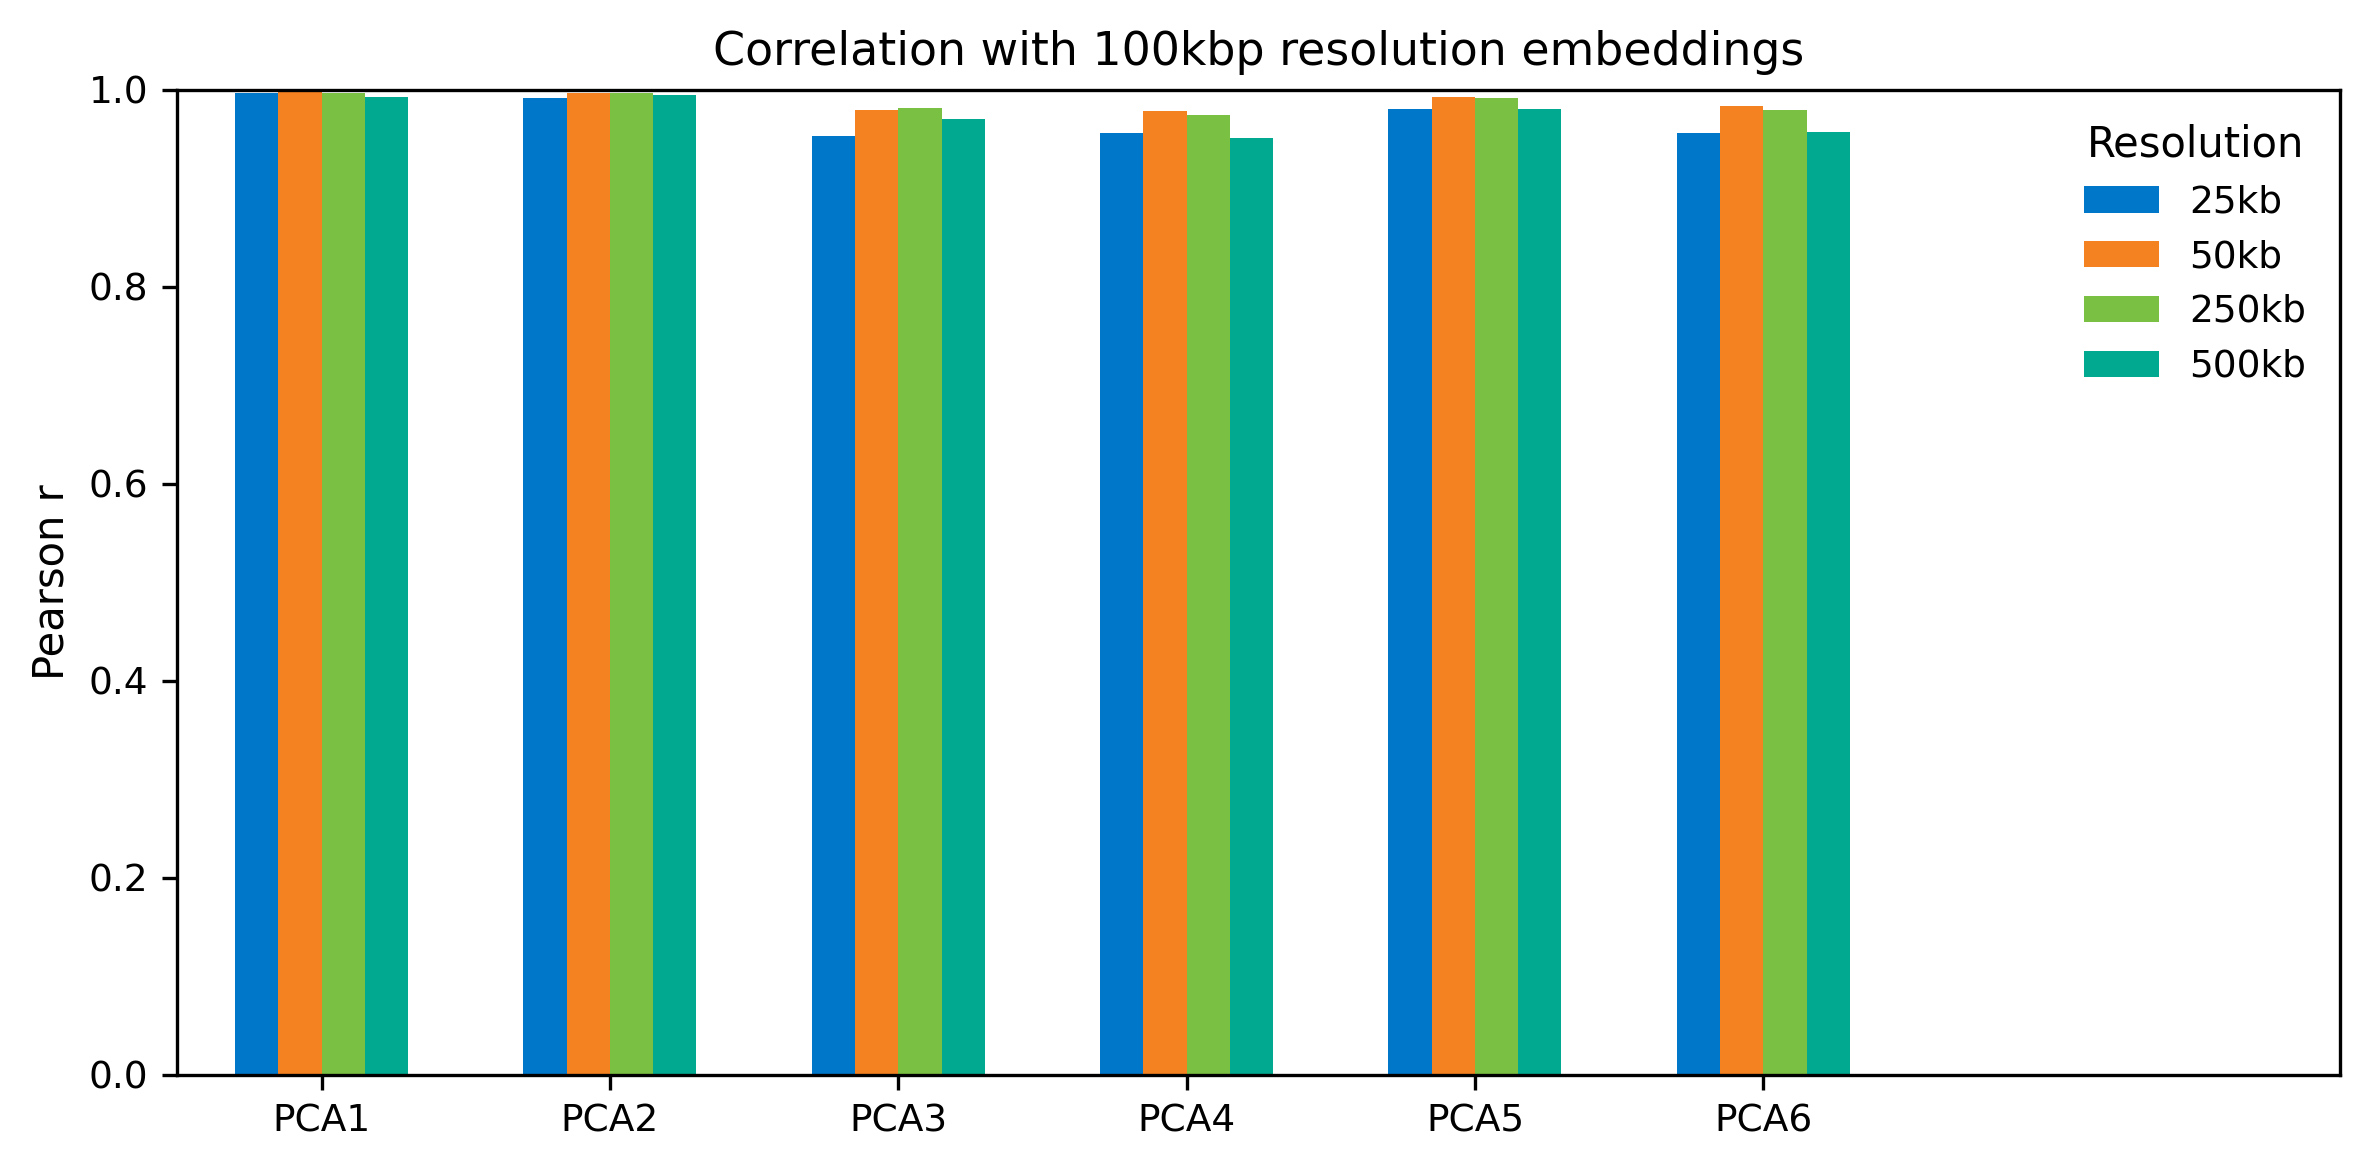

In [15]:
pcs = [f"PCA{i}" for i in range(1, trunc_pca + 1)]
res_labels = [f"{r}kb" for r in other_res]

x = np.arange(len(pcs))           # PC positions
width = 0.15                      # bar width
n_res = len(other_res)

plt.figure(figsize=(8, 4))

for j, res_label in enumerate(res_labels):
    # Offset bars so they form groups around each PC
    offset = (j - (n_res - 1) / 2) * width
    vals = [
        plot_df.loc[
            (plot_df["PC"] == pc) & (plot_df["resolution"] == res_label),
            "corr_vs_25kb"
        ].values[0]
        for pc in pcs
    ]
    plt.bar(x + offset, vals, width=width, label=res_label)

plt.xticks(x, pcs)
plt.ylabel("Pearson r")
plt.title("Correlation with 100kbp resolution embeddings")
plt.legend(title="Resolution", frameon=False)
plt.ylim(0, 1)  # optional, if correlations are all positive
plt.xlim(-0.5, 7)
plt.tight_layout()
plt.savefig(
    "jointly_hic_pca_corr_vs_100kbp_elsevier.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True,
)
plt.show()

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta

# -------------------------------------------------------------------
# 1. Encode the table exactly
# -------------------------------------------------------------------
bin_sizes = [25, 50, 100, 250, 500]

wall_time_str = [
    "20:04:40",
    "6:34:40",
    "2:36:49",
    "1:02:24",
    "0:25:18",
]

max_memory_mb_str = [
    "440,106",
    "110,740",
    "28,863",
    "9,559",
    "4,861",
]

avg_cpu_str = [
    "1711%",
    "1914%",
    "1478%",
    "1543%",
    "819%",
]

# -------------------------------------------------------------------
# 2. Convert strings to numeric values
# -------------------------------------------------------------------
def hms_to_hours(hms: str) -> float:
    h, m, s = map(int, hms.split(":"))
    td = timedelta(hours=h, minutes=m, seconds=s)
    return td.total_seconds() / 3600.0

wall_time_hours = [hms_to_hours(t) for t in wall_time_str]
max_memory_gb = [int(s.replace(",", "")) / 1000.0 for s in max_memory_mb_str]
avg_cpu_percent = [float(s.rstrip("%")) for s in avg_cpu_str]

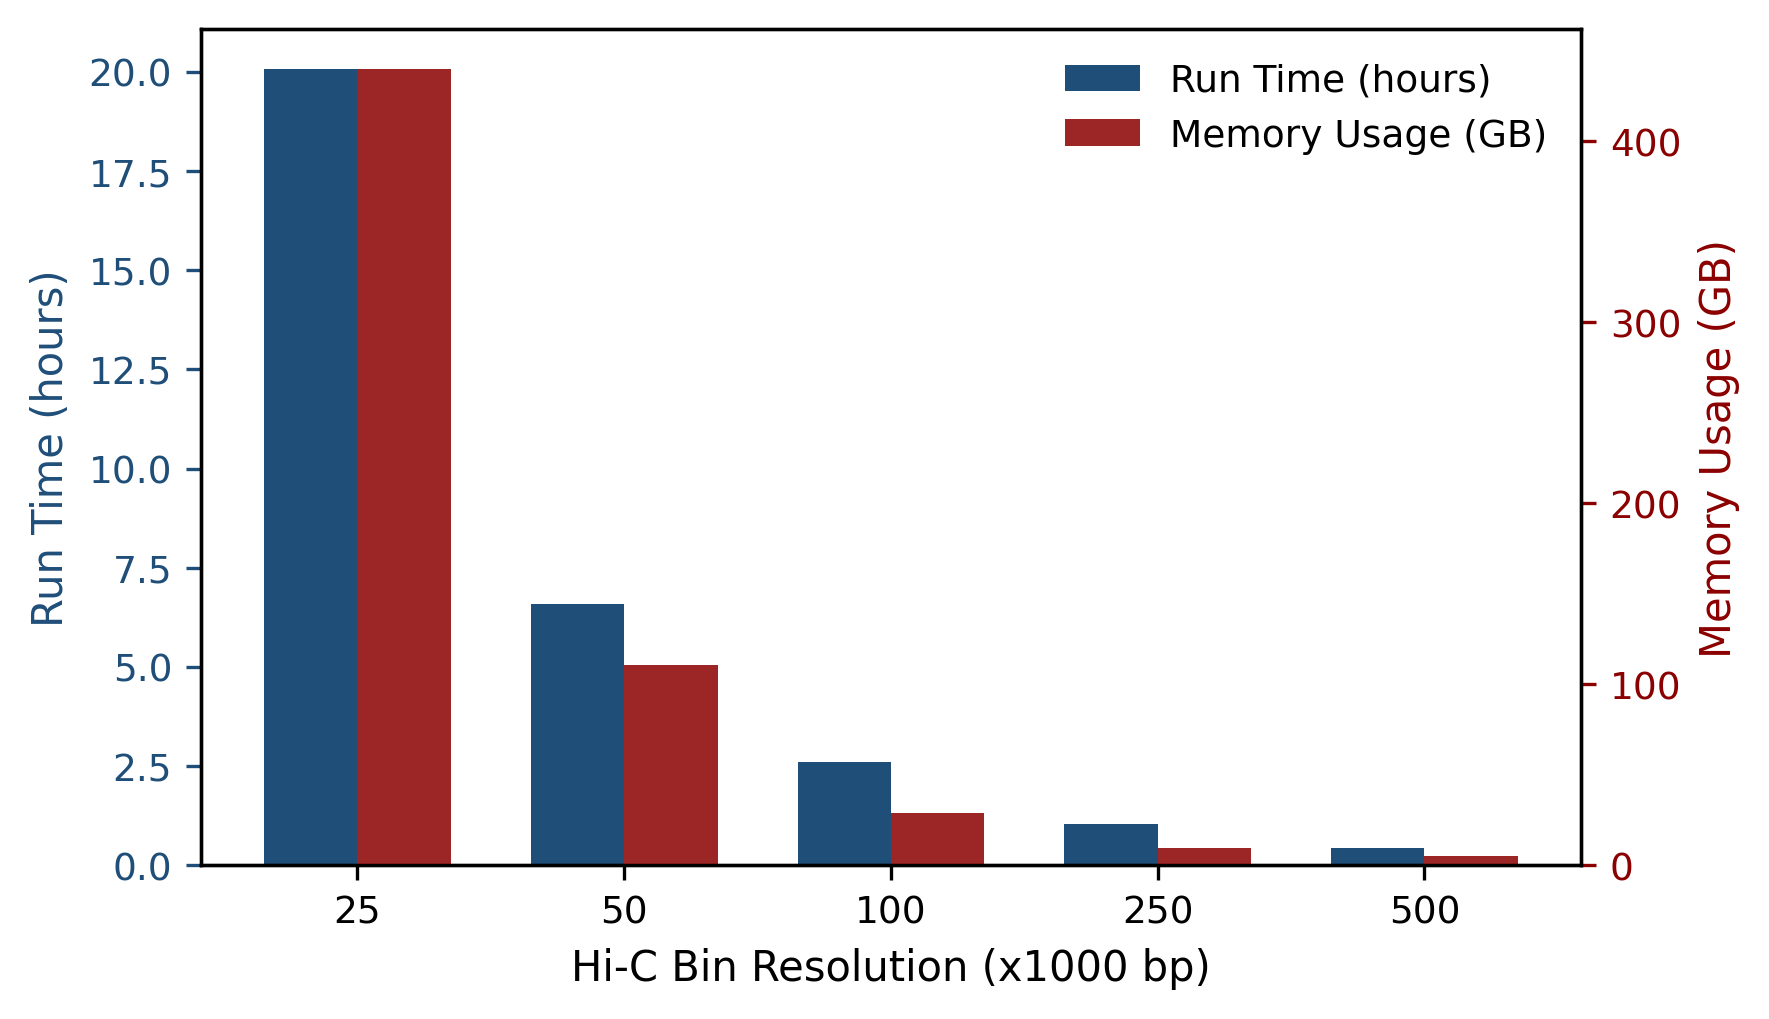

In [28]:
# -------------------------------------------------------------------
# 3. Dual-axis bar plot: Wall time (left), Max memory (right)
# -------------------------------------------------------------------
x = np.arange(len(bin_sizes))
width = 0.35

fig, ax1 = plt.subplots(figsize=(6, 3.5))

# Left-axis bars: wall time (blue)
bars1 = ax1.bar(
    x - width / 2,
    wall_time_hours,
    width=width,
    label="Run Time (hours)",
    color="#1f4e79",       # dark blue
)

ax1.set_xlabel("Hi-C Bin Resolution (x1000 bp)")
ax1.set_ylabel("Run Time (hours)", color="#1f4e79")
ax1.tick_params(axis="y", colors="#1f4e79")
ax1.set_xticks(x)
ax1.set_xticklabels([str(b) for b in bin_sizes])

# Right-axis bars: max memory (red)
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + width / 2,
    max_memory_gb,
    width=width,
    label="Memory Usage (GB)",
    color="#8b0000",   # dark red
    alpha=0.85,
)

ax2.set_ylabel("Memory Usage (GB)", color="#8b0000")
ax2.tick_params(axis="y", colors="#8b0000")

# Combined legend
bars = [bars1, bars2]
labels = [b.get_label() for b in bars]
ax1.legend(bars, labels, loc="upper right", frameon=False)

fig.tight_layout()
fig.savefig("jointly_hic_walltime_memory_dualaxis_colored.pdf",
            format="pdf", bbox_inches="tight")
plt.show()